Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

__NOTE__ to the user: In first use, this notebook cannot be run top to bottom. It assumes that you have a bunch of csv files that are created at different points in the notebook.

Thanks:
* https://jackmckew.dev/sentiment-analysis-text-cleaning-in-python-with-vader.html
* https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html


In [1]:
import pandas as pd
import numpy as np
import os.path
import re
import pickle 
from nlpUtils import aardvark as aa 
from sklearn.metrics import f1_score # auc if I get embeddings
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
# sns.set(font_scale=1.5)

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords as nltkStop
from nltk import ngrams

In [141]:
import importlib
importlib.reload(aa)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<module 'nlpUtils.aardvark' from 'c:\\Users\\rnocker\\Desktop\\python\\thesisAgain\\nlpUtils\\aardvark.py'>

# Setup
Assumes that you have completed vaderPrep

In [2]:
# Import the files that result from dataSplitBalance

unbal_x_train = pd.read_csv("dataBalSetsEcodes/unbal_x_train.csv", header=0, index_col=0)
unbal_x_val = pd.read_csv("dataBalSetsEcodes/unbal_x_val.csv", header=0, index_col=0)
unbal_y_train = pd.read_csv("dataBalancedSets/unbal_y_train.csv", header=0, index_col=0)
unbal_y_val = pd.read_csv("dataBalancedSets/unbal_y_val.csv", header=0, index_col=0)

# And the test dataset
x_test = pd.read_csv("dataBalSetsEcodes/x_test.csv", header=0, index_col=0)
y_test = pd.read_csv("dataBalancedSets/y_test_sent.csv", header=0, index_col=0)

# And some odds and ends
# tweets_clean  = pd.read_csv("dataBalSetsEcodes/tweets_clean.csv", header=0, index_col=0) 
# emoji_df_full = pd.read_csv("data/emoji_full_mod1.csv", header=0, index_col=0)
# all_unlabeled_tweets = pd.read_csv("archiveData/all_unlabeled_tweets_ecodes.csv", header=0, index_col=0)

print("Unbalanced:")
print("x-train:", unbal_x_train.shape, "x-val:", unbal_x_val.shape, "y-train:", unbal_y_train.shape, "y-val:", unbal_y_val.shape)
print("TEST DATA")
print("x-TEST:", x_test.shape, "y-TEST:", y_test.shape)
# emoji_df_full.head()


Unbalanced:
x-train: (823, 3) x-val: (206, 3) y-train: (823, 5) y-val: (206, 5)
TEST DATA
x-TEST: (182, 3) y-TEST: (182, 5)


# NOTES
* the tweet_clean is the full, unsplit set - NOT for model development, only for finding emojis.
* the unbalanced, and testing sets can be used for VADER model development


# Alternate Term Check

In [ ]:
my_count = 0
for id, text in zip(check_tweets.id_stable, check_tweets["ContentClean"]):
    if "🔜" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        print(id, ":", text)
        my_count += 1
my_count
# Orig: left behind: 3992 instances in master_tweets

# Summary
We have several data sets, using different balancing techinques. In the data, the emoji have been replaced with text codes.We ran the base model, unmodified, on the TEST data and reported these results to set a baseline for VADER: 
* VADER-base prediction F-score, TEST, macro average: 0.571
* VADER-base prediction F-score, VAL, macro average: 0.511

Now we want to see if we can beat that with a modified model. 

We will only be using the unbalanced datasets (train, val, test), as VADER does not learn directly from the data, it is not affeced by imbalance. Fine-tuning the model is done manually: looking at the TRAIN data, evaluating what updates might be helpful, and validating those changes on the VAL data. The final model will be run again on the TEST data and results reported. 

# Next
First, we want to see if we can improve emoji handling. 
1. Get the VADER-base score on the VAL data for comparison
2. Update the lexicon to recognize the text codes and corresponding values that we set
3. run the Bert model again on the VALIDATION data


VADER-base, VAL prediction F-score, macro average: 0.511

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       125
           1       0.53      0.42      0.47        43
           2       0.30      0.74      0.42        38

    accuracy                           0.54       206
   macro avg       0.55      0.56      0.51       206
weighted avg       0.67      0.54      0.56       206

Confusion matrix:
 [[65 11 49]
 [ 8 18 17]
 [ 5  5 28]]

Per-Class Confusion matrix:
 [[[ 68  13]
  [ 60  65]]

 [[147  16]
  [ 25  18]]

 [[102  66]
  [ 10  28]]]


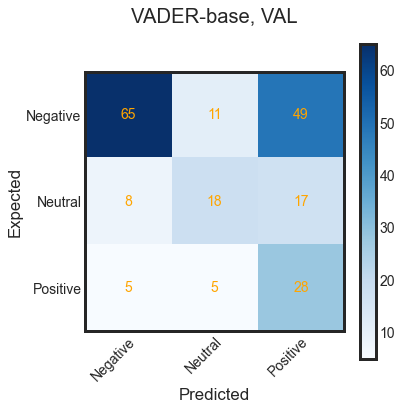

             count      mean       std     min     25%     50%       75%  \
y_true_test                                                                
0            125.0 -0.139031  0.544927 -0.9313 -0.6486 -0.1779  0.296000   
1             43.0  0.103428  0.440311 -0.8910  0.0000  0.0000  0.401650   
2             38.0  0.347795  0.381910 -0.6486  0.0320  0.3818  0.638175   

                max  
y_true_test          
0            0.8957  
1            0.8934  
2            0.9217  


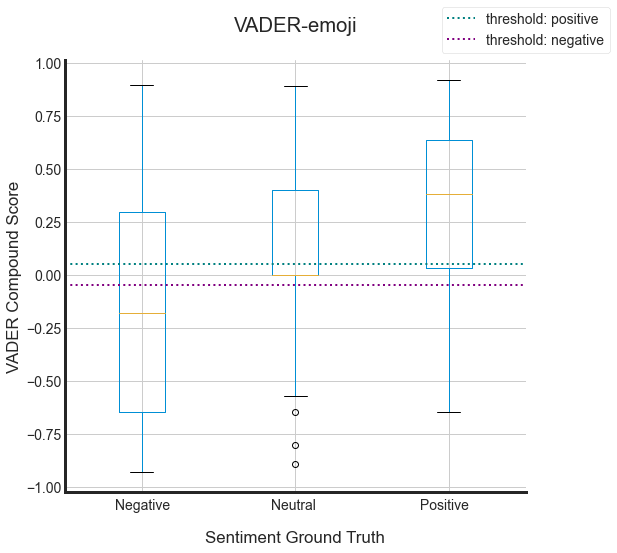

In [15]:
# If you have run the other model, reload aardvark before running this again
# importlib.reload(aa)

## Start by getting the VADER-base results on the VAL data, for comparison.
sid = SentimentIntensityAnalyzer() 

# Get the VADER compound score for the VAL data as a list
x_compound_VADERemoji = list(unbal_x_val["ContentClean"].apply(aa.vader_sent_compound))

# Get the VADERemoji prediction
y_pred_VADERemoji = unbal_x_val["ContentClean"].apply(aa.vader_pred)  #tweet, pos_cut = 0.05, neg_cut = -0.05

# Get the ground truth as a list
y_true_test = list(unbal_y_val["y_sent"])

# Get the prediction list
y_pred_VADERemoji = list(y_pred_VADERemoji)

# Get the metrics
aa.print_model_metrics (model_name = "VADER-base, VAL", y_true=y_true_test, y_pred=y_pred_VADERemoji, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-base, VAL", y_true=y_true_test, y_pred=y_pred_VADERemoji, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['x_compound_VADERemoji'] = x_compound_VADERemoji
vaderEmoji_df['y_pred_VADERemoji'] = y_pred_VADERemoji
vaderEmoji_df['y_true_test'] = y_true_test
print(vaderEmoji_df.groupby('y_true_test')['x_compound_VADERemoji'].describe())
aa.boxplot_results(model_name="VADER-emoji", df=vaderEmoji_df, score_col='x_compound_VADERemoji', y_true_col="y_true_test", pos_threshold=0.05, neg_threshold=-0.05)

In [ ]:
# # Load the sid and update it.
# sid = SentimentIntensityAnalyzer()

# a_file = open("data/change_lex.pkl", "rb")
# change_lex = pickle.load(a_file)
# a_file.close()

# sid.lexicon.update(change_lex)

# #Make sure we are using the updated lexicon; should output: 0.1891, 0.746
# # Note that the aa. functions don't use the updated lexicon!!!
# print(sid.polarity_scores("red_heart_e")["compound"])
# print(change_lex['red_heart_e'])

VADER-emoji prediction F-score, macro average: 0.487

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       125
           1       0.48      0.35      0.41        43
           2       0.29      0.74      0.41        38

    accuracy                           0.52       206
   macro avg       0.54      0.54      0.49       206
weighted avg       0.66      0.52      0.55       206

Confusion matrix:
 [[65 11 49]
 [ 8 15 20]
 [ 5  5 28]]

Per-Class Confusion matrix:
 [[[ 68  13]
  [ 60  65]]

 [[147  16]
  [ 28  15]]

 [[ 99  69]
  [ 10  28]]]


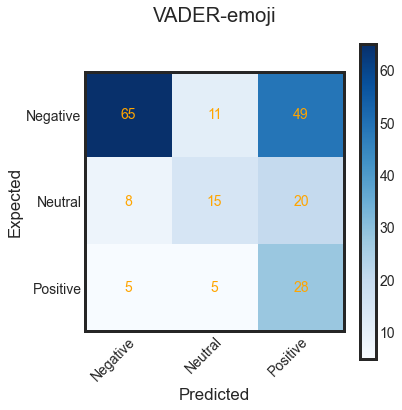

        count      mean       std     min     25%     50%       75%     max
y_true                                                                     
0       125.0 -0.139710  0.545797 -0.9313 -0.6486 -0.1779  0.296000  0.8957
1        43.0  0.132412  0.451151 -0.8910  0.0000  0.0000  0.411800  0.8934
2        38.0  0.348953  0.382194 -0.6486  0.0320  0.3818  0.638175  0.9253


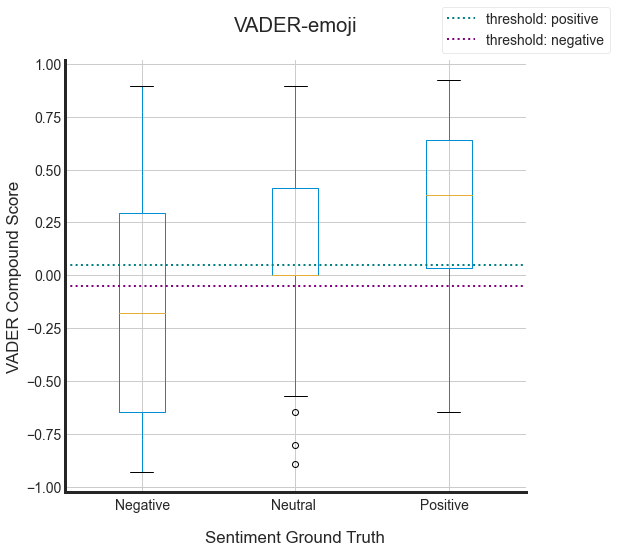

In [12]:
DATA = unbal_x_val
TRUE = unbal_y_val
MY_FN_C = aa.vader_sent_compound_update
Y_FN_P = aa.vader_pred_update

# STILL need to change the model name (in green) in 3 places

# Get the VADER compound score for the VAL data as a list
compound = list(DATA["ContentClean"].apply(MY_FN_C))

# Get the VADERemoji prediction
prediction = DATA["ContentClean"].apply(Y_FN_P)  #tweet, pos_cut = 0.05, neg_cut = -0.05

# Get the ground truth as a list
y_true = list(TRUE["y_sent"])

# Get the prediction list
prediction = list(prediction)

# Get the metrics
aa.print_model_metrics (model_name = "VADER-emoji", y_true=y_true, y_pred=prediction, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-emoji", y_true=y_true, y_pred=prediction, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['compound'] = compound
vaderEmoji_df['prediction'] = prediction
vaderEmoji_df['y_true'] = y_true
print(vaderEmoji_df.groupby('y_true')['compound'].describe())
aa.boxplot_results(model_name="VADER-emoji", df=vaderEmoji_df, score_col='compound', y_true_col="y_true", pos_threshold=0.05, neg_threshold=-0.05)

In [ ]:
# VADER-base, VAL prediction F-score, macro average: 0.511

#               precision    recall  f1-score   support

#            0       0.83      0.52      0.64       125
#            1       0.53      0.42      0.47        43
#            2       0.30      0.74      0.42        38

#     accuracy                           0.54       206
#    macro avg       0.55      0.56      0.51       206
# weighted avg       0.67      0.54      0.56       206


# VADER-emoji prediction F-score, macro average: 0.487

#               precision    recall  f1-score   support

#            0       0.83      0.52      0.64       125
#            1       0.48      0.35      0.41        43
#            2       0.29      0.74      0.41        38

#     accuracy                           0.52       206
#    macro avg       0.54      0.54      0.49       206
# weighted avg       0.66      0.52      0.55       206


So, it looks like this is making things a bit worse. 
* Not much change in precision, recall or f1 on the negative and positive classes
* Lower precision, recall or f1 on the neutral class

So there are emojis that the neutral tweets use that are pushing them further into one of the two camps. That makes sense. 

Theories about emoji that might cancel each other out:
* Extra theory: people use emoji sarcastically, which isn't being caught.
* Extra extra theory: but they also use it as a negator, which should help. And I *think* this should predominate.

Let's turn this off for now, and we can add it back in later.

In [19]:
importlib.reload(aa)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


<module 'nlpUtils.aardvark' from 'c:\\Users\\rnocker\\Desktop\\python\\thesisAgain\\nlpUtils\\aardvark.py'>

# Word Clouds
__NOTE: There is a lot of preprocessing below that is ONLY used to make the wordclouds. VADER has it's own way of dealing with things like punctuation, capitalization, stopwords, tokenization, lemmatization. And we don't necessarilly want to mass with / override that without validating.__

In order to refine the dictionaries, I need to know what words and bigrams/trigrams are common in which datasets. So let's make word clouds.

First I need to create a single text per pos, neg, and neutral. Then I can feed them into wordcloud. I'll use the TRAIN dataset to generate them.

First just all the ContentClean

In [17]:
# SETUP

# changes to tokenizer and lemmatizer --> UPDATE in aardvark, too.
w_tokenizer = nltk.tokenize.TweetTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

### Full Data Wordcloud
from the full dataset, stopwords removed

In [44]:
# Establish the initial set of stopwords as a set that can be modified later
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
train_words = ' '.join(unbal_x_train["ContentClean"])
a = aa.lemmatize_text(train_words)  # to change the tokenizer and lemmatizer from nltk, change in aardvark
lem_words = ' '.join(a)

dict_keys(['afghanistan', 'afghan', 'refugee', 'afghan refugee', 'taliban', 'country', 'people', 'asylum', 'united_states_e united_states_e', 'help', 'resettlement', 'wa', 'get', 'biden', 'new', 'uk', 'family', 'woman', 'many', 'need', 'resettle', 'translator', 'please', 'american', 'would', 'government', 'asylum seeker', 'like', 'year', 'life'])


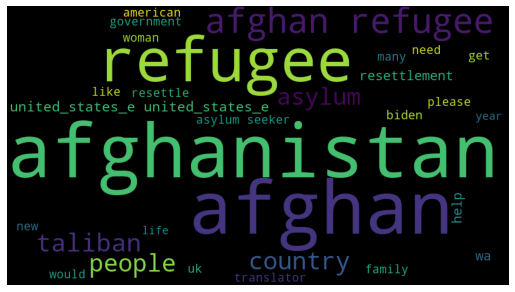

In [56]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words)
all_wc = wc.words_  # dictionary of the words used to make the cloud

print(all_wc.keys())
#print(WordCloud().process_text(lem_words))

plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


Need to break this down by label

In [47]:
print(list(unbal_x_train.columns))
print(list(unbal_y_train.columns))

['id_stable', 'Date', 'ContentClean']
['id_stable', 'label_sent', 'y_sent', 'label_stance', 'y_stance']


In [51]:
unbal_all_train = unbal_x_train.copy()
extracted_col = unbal_y_train["y_sent"].copy()
unbal_all_train = unbal_all_train.join(extracted_col)
unbal_all_train.head()

,id_stable,Date,ContentClean,y_sent
1191,5604,2022-03-30 21:49:53+00:00,"At the moment, that would be Mexican, Colombia...",0
52,56086,2021-10-11 06:48:52+00:00,Where went the promise of Afghan citizens rese...,0
816,39955,2021-11-26 22:09:37+00:00,What explanation does the government have for ...,0
481,44695,2021-11-12 12:37:18+00:00,"Iran Iran has provided shelter to 951,000 Afgh...",1
740,197583,2021-02-18 21:55:35+00:00,"Early 2016, a lefty grand-aunt of mine asked m...",0


In [72]:
# Break the data up per class
neg_list = []
neu_list = []
pos_list = []

for i, l in enumerate(unbal_all_train["y_sent"]):
    if l == 0:
        neg_list.append(unbal_all_train["ContentClean"].iloc[i])
    if l == 1:
        neu_list.append(unbal_all_train["ContentClean"].iloc[i])
    if l == 2:
        pos_list.append(unbal_all_train["ContentClean"].iloc[i])

# Turn the lists into long strings
neg_words = ' '.join(neg_list)
neu_words = ' '.join(neu_list)
pos_words = ' '.join(pos_list)

# Build the lists of lems
a = aa.lemmatize_text(neg_words)  # to change the tokenizer and lemmatizer from nltk, change in aardvark
lem_words_neg = ' '.join(a)

b = aa.lemmatize_text(neu_words)  # to change the tokenizer and lemmatizer from nltk, change in aardvark
lem_words_neu = ' '.join(b)

c = aa.lemmatize_text(pos_words)  # to change the tokenizer and lemmatizer from nltk, change in aardvark
lem_words_pos = ' '.join(c)

print(len(lem_words_neg))
print(len(lem_words_neu))
print(len(lem_words_pos))

99411
30165
30548


lem_words_neg


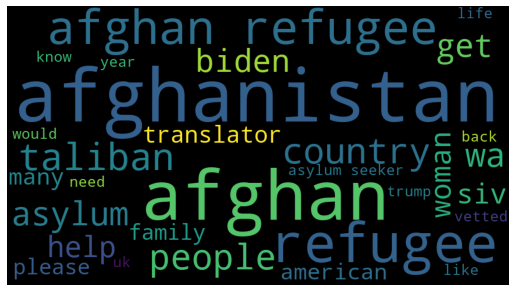

In [73]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_neg)
neg_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_neg")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


lem_words_neu


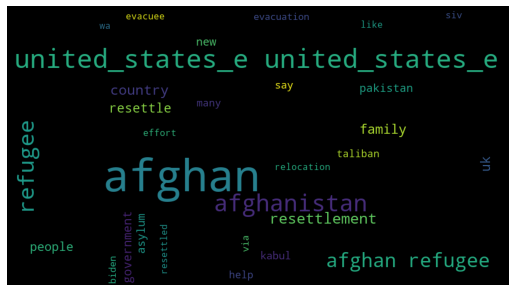

In [74]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_neu)
neu_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_neu")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


lem_words_pos


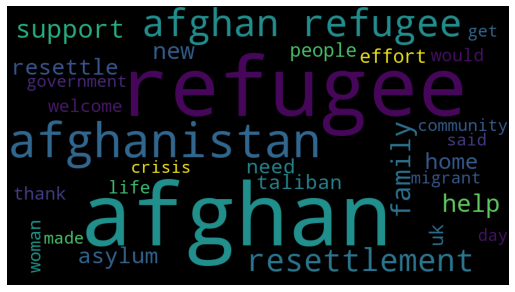

In [75]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_pos)
pos_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_pos")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [77]:
print(neg_wc.keys())
#print(WordCloud().process_text(text))
print()
print(neu_wc.keys())
#print(WordCloud().process_text(text))
print()
print(pos_wc.keys())
#print(WordCloud().process_text(text))


dict_keys(['afghanistan', 'afghan', 'refugee', 'afghan refugee', 'taliban', 'country', 'people', 'wa', 'asylum', 'get', 'biden', 'help', 'woman', 'siv', 'translator', 'many', 'american', 'family', 'please', 'asylum seeker', 'need', 'would', 'year', 'trump', 'vetted', 'know', 'back', 'life', 'uk', 'like'])

dict_keys(['afghan', 'united_states_e united_states_e', 'afghanistan', 'refugee', 'afghan refugee', 'resettlement', 'country', 'family', 'uk', 'resettle', 'people', 'government', 'asylum', 'new', 'pakistan', 'kabul', 'say', 'taliban', 'many', 'help', 'biden', 'via', 'siv', 'evacuation', 'evacuee', 'resettled', 'relocation', 'wa', 'effort', 'like'])

dict_keys(['afghan', 'refugee', 'afghanistan', 'afghan refugee', 'resettlement', 'family', 'support', 'help', 'new', 'asylum', 'resettle', 'home', 'need', 'taliban', 'people', 'effort', 'uk', 'welcome', 'woman', 'thank', 'would', 'life', 'crisis', 'community', 'made', 'said', 'get', 'government', 'migrant', 'day'])


So we can see that some words are in the top spot on all three maps:
* afghanistan
* afghan
* refugee

Other
* "united_states_e" is an emoji and I think this was just a tweet of 120-some of this one emoji

So these can all be added to the stopwords.

### NOTE: 
for now, I will be adding to the stopwords and rerunning the next two code boxes, rather than repeating them.

In [128]:
# stopwords = nltkStop.words('english') + ["Afghan","Afghanistan", "refugee"]
# stopwords = nltkStop.words('english') + ["Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['via', 'time', 'must', 'know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['made', 'said', 'day', 'already', 'via', 'time', 'must', 'know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['new', 'one', 'wa', 'like', 'made', 'said', 'day', 'already', 'via', 'time', 'must', 'know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
stopwords = nltkStop.words('english') + ['could', 'dont', 'even', 'group', 'today', 'really', 'new', 'one', 'wa', 'like', 'made', 'said', 'day', 'already', 'via', 'time', 'must', 'know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
#  

lem_words_neg


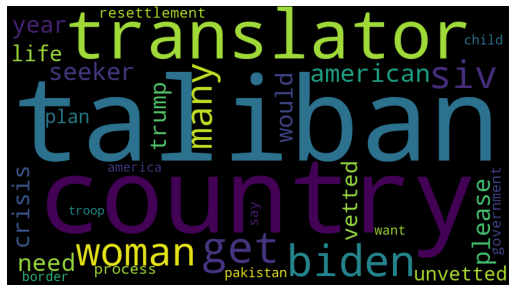

lem_words_neu


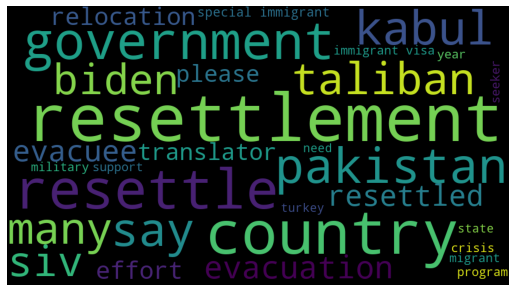

lem_words_pos


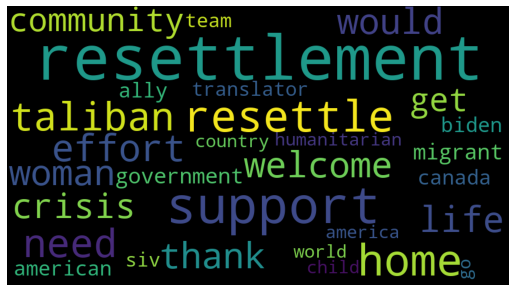

dict_keys(['taliban', 'country', 'translator', 'get', 'biden', 'woman', 'siv', 'many', 'american', 'seeker', 'please', 'need', 'would', 'year', 'crisis', 'trump', 'vetted', 'life', 'unvetted', 'plan', 'process', 'resettlement', 'government', 'say', 'child', 'pakistan', 'want', 'america', 'border', 'troop'])

dict_keys(['resettlement', 'country', 'resettle', 'government', 'pakistan', 'kabul', 'say', 'taliban', 'many', 'biden', 'siv', 'evacuation', 'evacuee', 'resettled', 'relocation', 'effort', 'translator', 'please', 'special immigrant', 'year', 'seeker', 'crisis', 'program', 'support', 'military', 'migrant', 'immigrant visa', 'state', 'turkey', 'need'])

dict_keys(['resettlement', 'support', 'resettle', 'home', 'need', 'taliban', 'effort', 'welcome', 'woman', 'thank', 'would', 'life', 'crisis', 'community', 'get', 'government', 'migrant', 'american', 'ally', 'canada', 'biden', 'translator', 'siv', 'team', 'world', 'america', 'humanitarian', 'child', 'go', 'country'])


In [129]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_neg)
neg_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_neg")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_neu)
neu_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_neu")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_pos)
pos_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_pos")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

print(neg_wc.keys())
#print(WordCloud().process_text(text))
print()
print(neu_wc.keys())
#print(WordCloud().process_text(text))
print()
print(pos_wc.keys())
#print(WordCloud().process_text(text))


In [130]:
negs, neuts, poss = list(neg_wc.keys()), list(neu_wc.keys()), list(pos_wc.keys())
neg_alone, neu_alone, pos_alone, joint, all_in, neu_neg_sep, neu_pos_sep = [], [], [], [], [], [], []

# Find words in just one class (one list) or in two or more (separate list)
for word in negs:
    if (word not in neuts) and (word not in poss):
        neg_alone.append(word)
    else: joint.append(word)
for word in neuts:
    if (word not in negs) and (word not in poss):
        neu_alone.append(word)
    else: joint.append(word)
for word in poss:
    if (word not in negs) and (word not in neuts):
        pos_alone.append(word)
    else: joint.append(word)

# find words in all three classes
for word in poss:
    if (word in negs) and (word in neuts):
        all_in.append(word)

# find words that are in both neg and neu, but with a wide discrepancy in weighted frequency (0.5 or greater)
for word in neuts:
    if word in negs:
        if (neu_wc[word] - neg_wc[word] > 0.5) or (neu_wc[word] - neg_wc[word] < -0.5):
            neu_neg_sep.append(word)

# find words that are in both neg and neu, but with a wide discrepancy in weighted frequency (0.5 or greater)
for word in neuts:
    if word in poss:
        if (neu_wc[word] - pos_wc[word] > 0.5) or (neu_wc[word] - pos_wc[word] < -0.5):
            neu_pos_sep.append(word)

print("all:", all_in)
print("sep: neg v neu:", neu_neg_sep)
print("sep: pos v neu:", neu_pos_sep)
print()
print("joint:", joint)
print()
print("neg:", neg_alone)
print("neu:",neu_alone)
print("pos:",pos_alone)


all: ['resettlement', 'need', 'taliban', 'crisis', 'government', 'biden', 'translator', 'siv', 'country']
sep: neg v neu: ['resettlement', 'taliban']
sep: pos v neu: ['country']

joint: ['taliban', 'country', 'translator', 'get', 'biden', 'woman', 'siv', 'many', 'american', 'seeker', 'please', 'need', 'would', 'year', 'crisis', 'life', 'resettlement', 'government', 'say', 'child', 'pakistan', 'america', 'resettlement', 'country', 'resettle', 'government', 'pakistan', 'say', 'taliban', 'many', 'biden', 'siv', 'effort', 'translator', 'please', 'year', 'seeker', 'crisis', 'support', 'migrant', 'need', 'resettlement', 'support', 'resettle', 'need', 'taliban', 'effort', 'woman', 'would', 'life', 'crisis', 'get', 'government', 'migrant', 'american', 'biden', 'translator', 'siv', 'america', 'child', 'country']

neg: ['trump', 'vetted', 'unvetted', 'plan', 'process', 'want', 'border', 'troop']
neu: ['kabul', 'evacuation', 'evacuee', 'resettled', 'relocation', 'special immigrant', 'program', 'm

### First run
I think the "U" is from people doint "U S" or "U K" or such. That can go.
* U, S, K
* UK
* US

You can really start to see why it's hard to break out the neutral group: there are words that are in pos and not in neg, and vice versa; but the words in neutral tend to also be on one of the others.

### Next
Now you can start to see some things:
* all: ['family', 'help', 'ha', 'asylum', 'taliban', 'people']
  * Taliban is in all three, but it is so much more weighted in the neg, that I think I will leave it in. The rest to stopwords.
    * neg: 'taliban': 1.0
    * neu: 'taliban': 0.4782608695652174
    * pos: 'taliban': 0.36363636363636365
* Doubled: 'county' is in neg and neu, but not pos. Maybe give this a very slight negative score? It should help with distinguishing between pos and neg, but not with separating out the problematic neutral class. And neutral does seem to overlap more with neg than pos, so this is proabably not a good idea.
  
### Next
We begin to have a good list of per-class words:
* neg: ['trump', 'vetted', 'know', 'back', 'unvetted', 'plan', 'process'] + taliban
* neu: ['pakistan', 'kabul', 'via', 'evacuation', 'evacuee', 'resettled', 'relocation', 'time', 'must', 'special immigrant', 'program']
* pos: ['home', 'welcome', 'thank', 'community', 'made', 'said', 'migrant', 'day', 'ally', 'canada', 'already']

### Next
* "resettlement" looks like it is double with neutral and positive, maybe slightly postitive?

### way down
* country now makes it onto the neu/pos sep list, but you have to go too far for this to be useful.
  
## Update the lexicon
* neg: ['trump', 'vetted', 'unvetted', 'plan', 'process', 'border', 'troop'] + taliban
* neu: ['kabul', 'evacuation', 'evacuee', 'resettled', 'relocation', 'program']
* pos: ['home', 'welcome', 'thank', 'community', 'ally', 'team', 'humanitarian''] + resettlement

I will put all the neutrals at 0. For pos (and neg) I will start with .8 and work down in steps of .05 (neg, for neg)

In [139]:
# neg: ['trump', 'vetted', 'unvetted', 'plan', 'process', 'border', 'troop', 'taliban']
# neu: ['kabul', 'evacuation', 'evacuee', 'resettled', 'relocation', 'program']
# pos: ['home', 'welcome', 'thank', 'community', 'ally', 'team', 'humanitarian', 'resettlement']

# Load the sid and update it.
sid = SentimentIntensityAnalyzer()

change_lex_words = {
    'trump' : -.8, 'vetted' : -.75, 'unvetted' : -.7, 'plan' : -.65, 'process' : -.6, 'border' : -.5, 'troop' : -.4, 'taliban' : -.3,
    'kabul' : 0, 'evacuation' : 0, 'evacuee' : 0, 'resettled' : 0, 'relocation' : 0, 'program' : 0,
    'home' : .8, 'welcome' : .75, 'thank' : .7, 'community' : .65, 'ally' : .6, 'team' : .5, 'humanitarian' : .4, 'resettlement' : .3}

sid.lexicon.update(change_lex_words)

#Make sure we are using the updated lexicon; should output: 0.1891, 0.746
# Note that the aa. functions don't use the updated lexicon!!!
print(sid.polarity_scores("troop")["compound"])
print(change_lex_words['troop'])


-0.1027
-0.4


In [142]:
# Save the new lexicon with pickle: save change_lex_words as a dictionary that can be loaded in other files
a_file = open("data/change_lex_words.pkl", "wb")
pickle.dump(change_lex_words, a_file)
a_file.close()

VADER-emoji prediction F-score, macro average: 0.487

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       125
           1       0.48      0.35      0.41        43
           2       0.29      0.74      0.41        38

    accuracy                           0.52       206
   macro avg       0.54      0.54      0.49       206
weighted avg       0.66      0.52      0.55       206

Confusion matrix:
 [[65 11 49]
 [ 8 15 20]
 [ 5  5 28]]

Per-Class Confusion matrix:
 [[[ 68  13]
  [ 60  65]]

 [[147  16]
  [ 28  15]]

 [[ 99  69]
  [ 10  28]]]


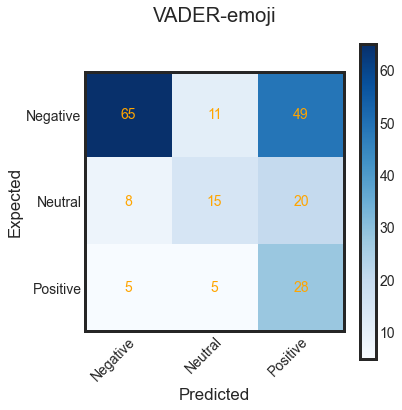

        count      mean       std     min     25%     50%       75%     max
y_true                                                                     
0       125.0 -0.139710  0.545797 -0.9313 -0.6486 -0.1779  0.296000  0.8957
1        43.0  0.132412  0.451151 -0.8910  0.0000  0.0000  0.411800  0.8934
2        38.0  0.348953  0.382194 -0.6486  0.0320  0.3818  0.638175  0.9253


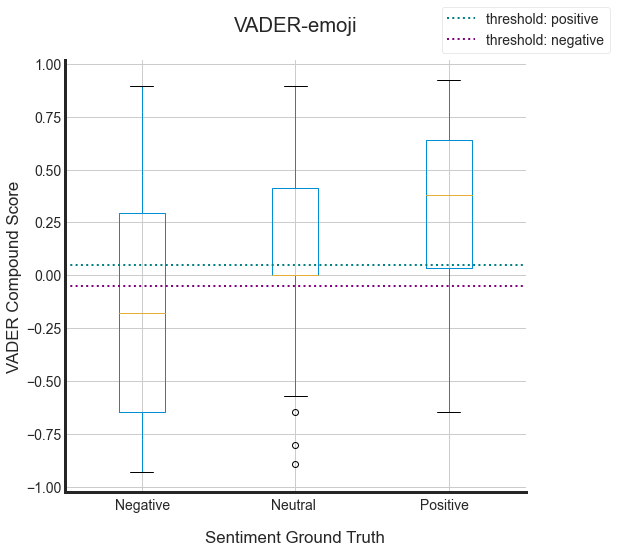

In [140]:
DATA = unbal_x_val
TRUE = unbal_y_val
MY_FN_C = aa.vader_sent_compound_update(pickle_path="data/change_lex_words.pkl")
Y_FN_P = aa.vader_pred_update(pickle_path="data/change_lex_words.pkl")

# STILL need to change the model name (in green) in 3 places

# Get the VADER compound score for the VAL data as a list
compound = list(DATA["ContentClean"].apply(MY_FN_C))

# Get the VADERemoji prediction
prediction = DATA["ContentClean"].apply(Y_FN_P)  #tweet, pos_cut = 0.05, neg_cut = -0.05

# Get the ground truth as a list
y_true = list(TRUE["y_sent"])

# Get the prediction list
prediction = list(prediction)

# Get the metrics
aa.print_model_metrics (model_name = "VADER-emoji", y_true=y_true, y_pred=prediction, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-emoji", y_true=y_true, y_pred=prediction, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['compound'] = compound
vaderEmoji_df['prediction'] = prediction
vaderEmoji_df['y_true'] = y_true
print(vaderEmoji_df.groupby('y_true')['compound'].describe())
aa.boxplot_results(model_name="VADER-emoji", df=vaderEmoji_df, score_col='compound', y_true_col="y_true", pos_threshold=0.05, neg_threshold=-0.05)

In [ ]:
# Now for the emoji version

# # Load the sid and update it.
# sid = SentimentIntensityAnalyzer()

# a_file = open("data/change_lex.pkl", "rb")
# change_lex = pickle.load(a_file)
# a_file.close()

# sid.lexicon.update(change_lex)

# #Make sure we are using the updated lexicon; should output: 0.1891, 0.746
# # Note that the aa. functions don't use the updated lexicon!!!
# print(sid.polarity_scores("red_heart_e")["compound"])
# print(change_lex['red_heart_e'])

# Word cloud by label
Now the labeled data, divied up by label.

In [ ]:
all_xy = pd.read_csv(os.path.join('data', "all_labeled_tweets.csv"), header=0, index_col=0)
print(list(all_xy.columns))

In [ ]:
d = ['Content', 'Labels', 'label_sent', 'label_stance', 'y_stance', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags', 'Flag']
master_labeled = all_xy.drop(d, axis=1)
master_labeled.sort_values(by=['Date'], inplace=True)
master_labeled.reset_index(drop=True, inplace=True)
print(master_labeled.shape)
master_labeled.tail()

In [ ]:
labeled_zero = master_labeled[master_labeled["y_sent"]==0].copy()  # neu
labeled_one = master_labeled[master_labeled["y_sent"]==1].copy()  # neg
labeled_two = master_labeled[master_labeled["y_sent"]==2].copy()  # pos
print(labeled_zero.shape)
print(labeled_one.shape)
print(labeled_two.shape)

### PAUSE / UNPAUSE

In [ ]:
# Pause
master_labeled.to_csv(os.path.join('dataVader', "master_labelel.csv"))
labeled_zero.to_csv(os.path.join('dataVader', "labeled_zero.csv"))
labeled_one.to_csv(os.path.join('dataVader', "labeled_one.csv"))
labeled_two.to_csv(os.path.join('dataVader', "labeled_two.csv"))

### Preprocess for wordcloud: Tokenize and Lemmatize 

In [ ]:
zero_words = ' '.join(labeled_zero["ContentClean"])
zero_lem = aa.lemmatize_text(zero_words)
zero_lem = ' '.join(zero_lem)

one_words = ' '.join(labeled_one["ContentClean"])
one_lem = aa.lemmatize_text(one_words)
one_lem = ' '.join(one_lem)

two_words = ' '.join(labeled_two["ContentClean"])
two_lem = aa.lemmatize_text(two_words)
two_lem = ' '.join(two_lem)

In [ ]:
# Neutral
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(zero_lem)
neu_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
# Negative
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(one_lem)
neg_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
# Positive
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(two_lem)
pos_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

Significant in all three:
* asylum (this is surprising)
* "ha" is in both pos and neg. Does Vader catch this as sarcastic in the neg? This should be an intensifier, not a sentiment.

Add negiative score to:
* Taliban
* unvetted
* left behind
* crisis

Add positive score to:
* community
* help/ing (and why are these not fied by the lemmatizer?)
* family (this is in neutral too, but I think it might help w positive)
* resettlement (this is in neg, but really small... and in neu, maybe slightly positive)
* Thank
* welcome
* support
* opportunity

### Bigrams and Trigrams

In [ ]:
# Neutral - up to trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(zero_lem)
neu_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [ ]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = zero_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_neu = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_neu, tri_neu = aa.bi_tri_freq(ngram_text_neu)
print("Neutral nGrams")
print(bi_neu[:25])
print()
print(tri_neu[:25])


In [ ]:
# Negative, trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(one_lem)
neg_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = one_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_neg = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_neg, tri_neg = aa.bi_tri_freq(ngram_text_neg)
print("Negative nGrams")
print(bi_neg[:25])
print()
print(tri_neg[:25])


In [ ]:
# Positive, trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(two_lem)
pos_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [ ]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = two_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_pos = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_pos, tri_pos = aa.bi_tri_freq(ngram_text_pos)
print("Neutral nGrams")
print(bi_pos[:15])
print()
print(tri_pos[:15])

In [ ]:
# dictionary of the words used to make the cloud
neu_wc
neu_words = []
for key, val in neu_wc.items():
    neu_words.append(key)

neu_bi_wc
neu_bigs = []
for key, val in neu_bi_wc.items():
    neu_bigs.append(key)

neg_wc
neg_words = []
for key, val in neg_wc.items():
    neg_words.append(key)

neg_bi_wc
neg_bigs = []
for key, val in neg_bi_wc.items():
    neg_bigs.append(key)

pos_wc
pos_words = []
for key, val in pos_wc.items():
    pos_words.append(key)

pos_bi_wc
pos_bigs = []
for key, val in pos_bi_wc.items():
    pos_bigs.append(key)

wc_words = pd.DataFrame({"neu words":neu_words, "neg words":neg_words, "pos words":pos_words, "neu nGrams":neu_bigs, "neg nGrams":neg_bigs, "pos nGrams":pos_bigs})
wc_words[:15]

In [ ]:
print("Neutral nGrams")
print(bi_neu[:10])
print(tri_neu[:10])
print()
print("Negative nGrams")
print(bi_neg[:10])
print(tri_neg[:10])
print()
print("Positive nGrams")
print(bi_pos[:10])
print(tri_pos[:10])


In [ ]:
# Should have included this in the aardvark function. Oh well.
#from sklearn.feature_extraction.text import CountVectorizer

words_in_text = list(ngrams(ngram_text_neu.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Neutral Tweets")
print(words_in_text_freq[:25])
print()

words_in_text = list(ngrams(ngram_text_neg.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Negative Tweets")
print(words_in_text_freq[:25])
print()

words_in_text = list(ngrams(ngram_text_pos.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Positive Tweets")
print(words_in_text_freq[:25])

In [ ]:
# Alternate approach: easier code, messier results.
from nltk.probability import FreqDist
pos_tok = ngram_text_pos.split(" ")
fdist = FreqDist(pos_tok)
fdist = fdist.most_common(5)
fdist

In [ ]:
# check_tweets = pd.read_csv(os.path.join('dataVader', "master_labelel.csv"), index_col=0, header=0)
check_tweets = pd.read_csv(os.path.join('dataVader', "master_tweets.csv"), index_col=0, header=0)


### ALTERNATE term check

In [ ]:
my_count = 0
for id, text in zip(check_tweets.id_stable, check_tweets["ContentClean"]):
    if "🔜" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        print(id, ":", text)
        my_count += 1
my_count
# Orig: left behind: 3992 instances in master_tweets

In [ ]:
aa.vader_sent_compound("embarrassing")

# Adding to VADER
### Stop Words 
VADER takes care of stop word removal. I would to refine what is considered a stopword, but that's surprisingly complicated. So instead we are going to change the lexicon to make the relevant words score = 0.

Add: all the ones that were used for WordCloud: "Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now", "UK", "wa", "ha", "say", "like", "via"

Also: "asylum", "seeker", "special", "family", "country"

In [ ]:
check_list = ["asylum", "seeker", "special", "family", "country", "Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now", "UK", "wa", "ha", "say", "like", "via"]
for i in check_list:
    print(i, ":", vader_sent_compound(i))  #💩

In [ ]:
change_lex["special"]=0
change_lex["like"] = 0
change_lex["ha"] = 0
sid.lexicon.update(change_lex)
# "ha" is in both pos and neg (sarcastic); this should be an intensifier, not a sentiment.

### New Dictionary terms
emojis

negative: left behind, unvetted, Taliban, Osama bin Laden, crisis

Positive: soccer, citizen, help, support, thank, welcome, hope

Neutral: resettle, resettlement

#thanks: https://stackoverflow.com/questions/40481348/is-it-possible-to-edit-nltks-vader-sentiment-lexicon

In [ ]:
check_list = ["left behind", "unvetted", "Taliban", "Laden", "crisis", "soccer", "citizen", "help", "support", "thank", "welcome", "hope", "resettle", "resettlement"]

for i in check_list:
    print(i, ":", vader_sent_compound(i))

In [ ]:
change_lex["left behind"] = -3
change_lex["unvetted"] = -2
change_lex["taliban"] = -1
change_lex["laden"] = -1  # In the full dataset, there are 123 " bin laden"s and 156 "laden"s; most of these are made up by just the most obvious misspellings (#osamabin: 6; binladen: 11; ben laden: 1). Good enough.
change_lex["soccer"] = 1
change_lex["citizen"] = 1
sid.lexicon.update(change_lex)

"left behind" needs to be changed into a single word for VADER to score it appropriately.

In [ ]:
print(aa.vader_sent_compound("left behind"))
change_lex["left_behind"] = 2
sid.lexicon.update(change_lex)
aa.vader_sent_compound("left_behind")

In [ ]:
my_count = 0
for id, text in zip(check_tweets.id_stable, x_train["ContentClean"]):
    if "left behind" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        #print(id, ":", text)
        my_count += 1
print(my_count)

my_count = 0
for id, text in zip(check_tweets.id_stable, x_train["ContentClean"]):
    if "left_behind" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        #print(id, ":", text)
        my_count += 1
print(my_count)

In [ ]:
for i, text in zip(x_train.index, x_train["ContentClean"]):
    x_train.loc[i, ["ContentClean"]] = text.lower().replace('left behind', 'left_behind')

### Now find the score

In [ ]:
x_train.drop(columns = ["VADERsid", "VADERcompound", "VADERpred"], axis = 1, inplace = True)
x_train.head()

In [ ]:

# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())


In [ ]:
# Use the same "true" as above
# Get the prediction list
lex1_pred = list(x_train["VADERpred"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=lex1_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=lex1_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER_lex1 F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER_lex1 F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

This is a little bit better, but really not much. And not over the baseline.
* Underpredicting neutral
* Underpredicting negative
* Overpredicting positive

Baseline: Majority Class Prediction
* Majority class prediction F-score, micro average: 0.606
* Majority class prediction F-score, macro average: 0.252

VADER-base, untuned:
* VADER-base F-score, micro average: 0.543
* VADER-base F-score, macro average: 0.502

VADER-base, lexicon with updated sentiment terms
* VADER_lex_ F-score, micro average: 0.563
* VADER_lex_ F-score, macro average: 0.521


In [ ]:
frames = [x_train, y_train_sent]
train_temp = pd.concat(frames, axis=1)
train_temp.drop(["Date", "Content", "ContentClean", "VADERsid"], axis=1, inplace=True)
train_temp = train_temp.iloc [:, [0, 1, 2, 4]]  
train_temp.columns = ["id_stable", "VADERcompound", "VADERpred", "GroundTruth"]
print(train_temp.shape)

In [ ]:
train_temp.groupby('GroundTruth')['VADERcompound'].describe()

In [ ]:
print("VADER Compound Score grouped by Ground Truth")
train_temp.boxplot(by='GroundTruth', column='VADERcompound', figsize=(10,8))

### PAUSE / UNPAUSE

In [ ]:
# PAUSE
x_train.to_csv(os.path.join('dataVader', "x_train_VADERlex.csv"))
#x_val.to_csv(os.path.join('dataVader', "x_val_VADERlex.csv"))   NOT done yet 


In [ ]:
# UNPAUSE
x_train = pd.read_csv(os.path.join('dataVader', "x_train_VADERlex.csv"), header=0, index_col=0)
x_val = pd.read_csv(os.path.join('dataVader', "x_val_VADERlex.csv"), header=0, index_col=0)
y_train_sent = pd.read_csv(os.path.join('data', "y_train_sent.csv"), header=0, index_col=0)
y_val_sent = pd.read_csv(os.path.join('data', "y_val_sent.csv"), header=0, index_col=0)

### Add new emojis to the lexicon

In [ ]:
emoji_df = pd.read_csv(os.path.join('dataVader', "emoji_score.csv"), header=0, index_col=0)
emoji_lex = emoji_df[emoji_df["VADERscore"]==0].copy()
emoji_lex.drop("VADERscore", axis=1, inplace=True)
emoji_lex.head()

I'm going to do the scoring in Excel.

In [ ]:
emoji_lex.to_csv("emoji_lex.csv")

In [ ]:
emoji_lex2 = pd.read_csv(os.path.join('dataVader', "emoji_lex_myScore.csv"), header=0, index_col=0)
emoji_lex2.tail()

# emoji_lex2 = pd.read_csv("emoji_lex.csv", header=0, index_col=0)

So, apparently VADER transforms emoji to text before extracting sentiment. I'm not exactly sure how this works: since it seems to map emoji to some pretty common words, I'm not sure how updating these sentiments would work. So I'm going to do the word transformation myself, then add those words to the lexicon with my scores.

In [ ]:
# del emoji_lex
# del emoji_lex2

In [ ]:
frames = [emoji_lex, emoji_lex2]
emoji_lex = pd.concat(frames, axis=1)
# emoji_lex.drop(columns=["demoji", "emosentScore"], inplace=True)
emoji_lex.drop(columns=["emoji", "demoji", "emosentScore"], inplace=True)
emoji_lex = emoji_lex[emoji_lex["lexScore"] != 0]
emoji_lex = dict(zip(emoji_lex["name"], emoji_lex["lexScore"]))
emoji_lex

In [ ]:
sid.lexicon.update(emoji_lex)

In [ ]:
print(vader_sent_compound("person_shrugging"))
print(vader_sent_compound("clown_face"))
print(vader_sent_compound("my_broken_heart"))

So that works to update VADER.

Now to make the transformation in the data.

In [ ]:
a = emoji_df[emoji_df["VADERscore"]==0].copy()
a.drop("VADERscore", axis=1, inplace=True)
a.tail()

In [ ]:
frames = [a, emoji_lex2]
emoji_dataUpdate = pd.concat(frames, axis=1)
emoji_dataUpdate.tail()

In [ ]:
emoji_dataUpdate.loc[70, "emoji"] = "💔"
emoji_dataUpdate.loc[71, "emoji"] = "😔"
emoji_dataUpdate.loc[72, "emoji"] = "😥"
emoji_dataUpdate.tail()

In [ ]:
emoji_dataUpdate.drop(columns=["demoji", "emosentScore", "lexScore"], inplace=True)
emoji_dataUpdate.tail()

### PAUSE / UNPAUSE

In [ ]:
x_train.to_csv(os.path.join('dataVader', "temp_x_train.csv"))

In [ ]:
x_train = pd.read_csv(os.path.join('dataVader', "temp_x_train.csv"), index_col=0, header=0)
x_train.tail()

### Cont.

In [ ]:
print(aa.term_check("💀", x_train))  #💀 sk_ull
print(aa.term_check("sk_ull", x_train))  #💀 sk_ull
print(aa.term_check("💔", x_train))
print(aa.term_check("my_broken_heart", x_train))

aa.term_check("person_shrugging", x_train)


In [ ]:
for i, text in zip(x_train.index, x_train["ContentClean"]):
    if "‼️" in text:
        x_train.loc[i, ["ContentClean"]] = text.replace("‼️", "!!")
    if "👊" in text:
        x_train.loc[i, ["ContentClean"]] = text.replace("👊", "!")
    for emj, nme in zip(emoji_dataUpdate["emoji"], emoji_dataUpdate["name"]):
        if emj in text:
            x_train.loc[i, ["ContentClean"]] = text.replace(emj, str(" "+nme+" "))
    

## Find new scores

In [ ]:
# sid.lexicon.update(change_lex)
print(vader_sent_compound("left_behind"))
print(vader_sent_compound("💀"))
print(vader_sent_compound("sk_ull"))
print(vader_sent_compound("💔"))
print(vader_sent_compound("my_broken_heart"))
print(vader_sent_compound("person_shrugging"))

In [ ]:
# x_train.drop(columns=["VADERsid", "VADERcompound", "VADERpred"], axis=1, inplace=True)
# x_train.head()

In [ ]:
# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())

In [ ]:
# Use the same "true" as above
# Get the prediction list
lex2_pred = x_train["VADERpred"].tolist()

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=lex2_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=lex2_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-base w emoji lexicon, F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-base w emoji lexicon, F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

In [ ]:
frames = [x_train, y_train_sent]
train_temp = pd.concat(frames, axis=1)
train_temp.drop(["Date", "Content", "ContentClean", "VADERsid"], axis=1, inplace=True)
train_temp = train_temp.iloc [:, [0, 1, 2, 4]]  
train_temp.columns = ["id_stable", "VADERcompound", "VADERpred", "GroundTruth"]
print(train_temp.shape)

In [ ]:
train_temp.groupby('GroundTruth')['VADERcompound'].describe()

In [ ]:
print("VADER Compound Score grouped by Ground Truth")
train_temp.boxplot(by='GroundTruth', column='VADERcompound', figsize=(10,8))

So, this changes NOTHING. I guess not many rows have emojis, and/or those rows were already predicted correctly.

* Underpredicting neutral
* Underpredicting negative
* Overpredicting positive

Baseline: Majority Class Prediction
* Majority class prediction F-score, micro average: 0.606
* Majority class prediction F-score, macro average: 0.252

VADER-base, untuned:
* VADER-base F-score, micro average: 0.543
* VADER-base F-score, macro average: 0.502

VADER-base, lexicon with updated sentiment terms
* VADER_lex_ F-score, micro average: 0.563
* VADER_lex_ F-score, macro average: 0.521

VADER-base w emoji lexicon
* VADER-base w emoji lexicon, F-score, micro average: 0.563
* VADER-base w emoji lexicon, F-score, macro average: 0.521


# Find and Remove more News
Ok, so we discovered when dealing with the emojis that several of them are reliable indicators of news articles or other irrelevant rows:
* 🎙️: audio broadcasts, esp. podcasts
* 🆕: new infomration
* 📡: on the radar
* 📊: data given
* 📅: event schedule   #DO THIS ONE LATER


In [ ]:
## IN THE FULL DATASET
print(check_tweets.shape)
my_count = 0
for id, text in zip(check_tweets.id_stable, check_tweets["ContentClean"]):
    if "🆕" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        print(id, ":", text)
        my_count += 1
my_count

In [ ]:
my_count=0
print(x_train.shape)
for id, text in zip(x_train.id_stable, x_train["ContentClean"]):
    if "new_button" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        my_count += 1
my_count


In [ ]:
list = ["studio_microphone", "NEW_button", "satellite_antenna", "bar_chart"]
indx_list = []
# for i, text in zip(x_train.index, x_train["ContentClean"]):
#     for emj in list:
#         if emj in text:
#             indx_list.append(i)
for id, text in zip(x_train.index, x_train["ContentClean"]):
    if "bar_chart" in text:
        print(i)

indx_list


This is not in enough rows to be worth it.

# Reset the category thresholds
I think the VADER people wanted to keep "neutral" as small as possible. That makes sense when you are talking about a simple subject. It's less useful when topics are complex (lots of pros and cons) and undecided or neutral is a viable stance to take on the subject.

So let's widen the thresholds.

In [ ]:
def vader_pred_var(tweet):
    scores = sid.polarity_scores(tweet)
    comp = scores["compound"]
    if comp >= 0.1:
        return 2
    elif comp <= -.01:
        return 1
    else:
        return 0

In [ ]:
# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred_var)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())

In [ ]:
# Use the same "true" as above
# Get the prediction list
threshold_pred = x_train["VADERpred"].tolist()

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=threshold_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=threshold_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-threshold F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-threshold F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

So, disappointingly, this also does very little. Because there is so much overlap, moving the threshold may help one class, but it will about equally hurt another. There has to be better separation betwteen classes in order for this to work.

NOTE: no need for boxplots, as the distribution hasn't changed.

Unfortunately, I think I have to leave the analysis there and move on to writeup. I don't have time to keep working on this now.

# Now make the selected transformations on the validate data and the full dataset.
* sid.lexicon.update(change_lex)
* replace "left behind" with "left_behind"
* replace new emojis with the text equivalent in 

# TO CONSIDER, esp. for BERT
* expand contractions
* remove links, URLs
* Replace emoji w standard text
* What to do with hashtags
* remove capitalization 
* What to do with punctuation: ! or ? should be useful for sentiment. Maybe " " for sarcasm?
* remove whitespaces
* Bertmoticon package, which is fine-tuned to the BERT model.
* remove stop words beyond the standard NLTK stop words
    * Create WordClouds to find prominant but useless words
    * Ex: days of the week and their abbreviations, month names, and the word “Twitter” 
* deal w negations
    * create a dictionary of negations so that negated words could be effectively handled
* tokenize 
* stemming (via PorterStemmer)
* REMEMBER:
    * Hashtags is filled with "No hashtags"
    * Location is filled with "English-speaking"